*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  06.02.2024

--- 

# Emission calculation

<!--Notebook description and usage information-->
This notebook is used to calculate the final emission inventory


In [1]:
import sys
import multiprocessing
import geopandas as gpd
import pandas as pd

sys.path.append('../utils')
import data_paths
from traffic_counts import TrafficCounts
from hbefa_hot_emissions import HbefaHotEmissions
from hot_emission_process import process_daily_emissions

# Import Data and Initialize Objects
- import visum model data
- initialize traffic cycles and emission factors object

In [2]:
# import visum model
visum_links = gpd.read_file(data_paths.VISUM_FOLDER_PATH + 'visum_links.gpkg')
boarders = gpd.read_file(data_paths.MUNICH_BOARDERS_FILE).to_crs(25832)
visum = gpd.clip(visum_links, boarders)
visum = visum.explode(ignore_index=True) # convert multipolygons to polygons

visum = visum_links
visum = visum.reset_index(drop = True).reset_index() # reset index for calculation

# initialize traffic cycles
cycles = TrafficCounts()
# initialize HBEFA emission factors
hbefa = HbefaHotEmissions()

Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_PC.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_LCV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_HGV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_Coach.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_MOT.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/ef_aggregated_los/EFA_HOT_Vehcat

# Process Inventory
Use multiprocessing to calculate the emission for each road link day by day. This process will take some time to be finished for the whole area of interest.

In [3]:
year = '2019'

# select emission factor mode
mode = 'aggregated' 
#mode = 'los_specific'

start_date = f'{year}-01-01'
end_date = f'{year}-12-31'

NUMBER_OF_PROCESSES = 7

dates = [d.strftime("%Y-%m-%d") for d in pd.date_range(start = start_date,
                                                       end = end_date,
                                                       freq = '1d')]

with multiprocessing.Manager() as manager: 
    
    result_queue = manager.Queue()
    error_queue = manager.Queue()
    
    with multiprocessing.Pool(NUMBER_OF_PROCESSES) as pool:
        parameters = [(d,
                       mode,
                       visum.to_dict('records'),cycles,
                       hbefa,
                       result_queue,
                       error_queue,
                       ) for d in dates]
        
        res = pool.starmap(process_daily_emissions, parameters)
    
    # concatenate final process results.
    result = result_queue.get() #get first result from queue
    while not result_queue.empty():
        print('Concatenate final process results')
        new_result = result_queue.get()
        for road_index, emissions in result.items():
            for component, value in emissions.items():
                add_emissions = new_result[road_index][component]
                result[road_index][component] += add_emissions
                
    # retrieve process errors
    errors = list()
    while not error_queue.empty(): 
        errors.append(error_queue.get())

Finished calculating 2019-01-01
Finished calculating 2019-01-15
Finished calculating 2019-01-29
Finished calculating 2019-02-12
Finished calculating 2019-02-26
Finished calculating 2019-03-12
Finished calculating 2019-03-26
Finished calculating 2019-01-02
Finished calculating 2019-01-16
Finished calculating 2019-01-30
Finished calculating 2019-02-27
Finished calculating 2019-02-13
Finished calculating 2019-03-27
Finished calculating 2019-03-13
Finished calculating 2019-01-03
Finished calculating 2019-01-17
Finished calculating 2019-01-31
Finished calculating 2019-02-28
Finished calculating 2019-02-14
Finished calculating 2019-03-28
Finished calculating 2019-03-14
Finished calculating 2019-01-04
Finished calculating 2019-01-18
Finished calculating 2019-02-01
Finished calculating 2019-03-15
Finished calculating 2019-03-01
Finished calculating 2019-02-15
Finished calculating 2019-01-05
Finished calculating 2019-03-29
Finished calculating 2019-01-19
Finished calculating 2019-02-16
Finished

In [4]:
# print errors
for e in errors:
    print (e)

# Concatenate Results
All results are saved in result dict. This can be appended to the traffic model. 
Additionally, the traffic model is clipped to the region of interest by the administration boarders of the city of Munich.
Finally, the emission calculation results are multiplied with the road length of the respective road link to get final emissions.

In [5]:
# concatenate results and multiply with road length
result_df = pd.DataFrame(result).transpose()
result_df.columns = result_df.columns.map('_'.join)
visum_result = pd.concat([visum, result_df], axis = 1)

In [6]:
(visum_result['PC_CO2(rep)'] * visum_result['geometry'].length).sum() * 1e-12

1795.1481305675181

In [9]:
visum_test = gpd.clip(visum_result, boarders)

In [11]:
(visum_test['PC_CO2(rep)'] * visum_test['geometry'].length).sum() * 1e-12

873.8943517907802

<Axes: >

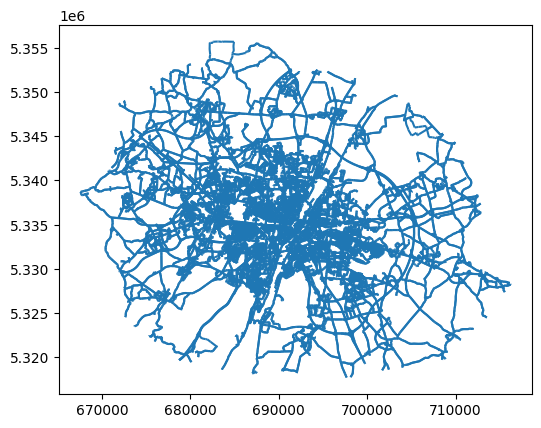

In [8]:
visum_result.plot()

# Save results

In [7]:
path = data_paths.INVENTORY_FOLDER_PATH
visum_result.to_file(path+f'linesource_Munich_{year}_aggregated_ef.gpkg', driver='GPKG')

# Calculate and Save Timeprofiles

In [74]:
save_path = data_paths.INVENTORY_FOLDER_PATH +'/temporal_profiles/'

for year in [2019, 2020, 2021, 2022]:
    df = pd.DataFrame()
    for vc in ['PC', 'LCV', 'HGV', 'MOT', 'BUS']:
        start = f'{year}-01-01'
        end = f'{year}-12-31'
        c1 = cycles.timeprofile['Distributor/Secondary'][vc].loc[start:end]/cycles.timeprofile['Distributor/Secondary'][vc].loc[start:end].mean()
        c2 = cycles.timeprofile['Motorway-Nat'][vc].loc[start:end]/cycles.timeprofile['Motorway-Nat'][vc].loc[start:end].mean()
        c3 = cycles.timeprofile['TrunkRoad/Primary-City'][vc].loc[start:end]/cycles.timeprofile['TrunkRoad/Primary-City'][vc].loc[start:end].mean()
        
        cycle = pd.concat([c1,c2,c3], axis = 1).mean(axis =1)
        cycle.name = vc
        df = pd.concat([df,cycle], axis =1)
        df.to_csv(save_path + f'{year}_temporal_profile_traffic_hot.csv')
